<a href="https://colab.research.google.com/github/InbalBolshinsky/Deep-Learning-Assigments/blob/main/Exrecise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install kagglehub


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import kagglehub

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import kagglehub
path = kagglehub.dataset_download("aakashverma8900/bitcoin-price-usd")

print("Path to dataset files:", path)

import os

# List all files and subdirectories in the dataset folder
for root, dirs, files in os.walk(path):
    print(f"Root Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")
    print("-" * 40)


Path to dataset files: /root/.cache/kagglehub/datasets/aakashverma8900/bitcoin-price-usd/versions/1
Root Directory: /root/.cache/kagglehub/datasets/aakashverma8900/bitcoin-price-usd/versions/1
Subdirectories: []
Files: ['main.csv']
----------------------------------------


In [ ]:


# -------------------------------
# 1. Dataset Selection & Loading
# -------------------------------
DATA_PATH = "/root/.cache/kagglehub/datasets/aakashverma8900/bitcoin-price-usd/versions/1/main.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Data file not found: {DATA_PATH}")

df = pd.read_csv(DATA_PATH)




# Use all numerical columns for prediction
features = ['Open Time', 'Open', 'High', 'Low']


# -------------------------------
# 2. Preprocessing
# -------------------------------
# Scale all feature columns to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
df[features] = scaler.fit_transform(df[features])

# Convert to numpy array
all_data = df[features].values

# Create sequences for time series
seq_length = 1400  # Number of time steps in each input sequence

def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data) - seq_len):
        x = data[i : i + seq_len, :]  # Input: all features
        y = data[i + seq_len, 3]  # Target: 'Close' (index 3)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

X_data, Y_data = create_sequences(all_data, seq_length)

# Train-Test Split (80% train, 20% test)
train_size = int(len(X_data) * 0.8)
X_train, X_test = X_data[:train_size], X_data[train_size:]
Y_train, Y_test = Y_data[:train_size], Y_data[train_size:]

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

# PyTorch Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train, Y_train)
test_dataset  = TimeSeriesDataset(X_test,  Y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)


In [ ]:
print(df.tail())

        Open Time      Open      High       Low     Close     Volume  \
188312   0.999979  0.800794  0.796959  0.803033  57485.07  42.575735   
188313   0.999984  0.799909  0.796131  0.802534  57481.49  34.205467   
188314   0.999989  0.799693  0.796507  0.802299  57470.00  30.211789   
188315   0.999995  0.799497  0.795399  0.800708  57450.90  45.354728   
188316   1.000000  0.798974  0.795556  0.801679  57450.19  14.168318   

           Close Time  Quote asset volume  Number of trades  \
188312  1620794159999        2.448258e+06              1195   
188313  1620794219999        1.966194e+06              1096   
188314  1620794279999        1.736514e+06               955   
188315  1620794339999        2.605080e+06              1559   
188316  1620794399999        8.140594e+05               730   

        Taker buy base asset volume  Taker buy quote asset volume  
188312                    15.319691                 880913.090845  
188313                    15.971891                 

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim=5, hidden_dim=64, num_layers=1, output_dim=1):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim,
                            num_layers=num_layers, batch_first=True)
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim, device=x.device)

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Last time step output
        return out

device = "cuda" if torch.cuda.is_available() else "cpu"
model = LSTMModel(input_dim=len(features), hidden_dim=64, num_layers=1, output_dim=1).to(device)



In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
import torch

# Define criterion, optimizer, and scheduler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

num_epochs = 20
train_losses, val_losses = [], []
best_val_loss = float('inf')  # Initialize best validation loss as infinity

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device).unsqueeze(-1)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    train_losses.append(running_train_loss / len(train_loader))

    # Validation
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for x_val, y_val in test_loader:
            x_val, y_val = x_val.to(device), y_val.to(device).unsqueeze(-1)
            val_out = model(x_val)
            val_loss = criterion(val_out, y_val)
            running_val_loss += val_loss.item()

    val_losses.append(running_val_loss / len(test_loader))

    # Save the best model
    current_val_loss = val_losses[-1]
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        torch.save(model.state_dict(), "best_model.pth")  # Save the model
        print(f"Best model saved at epoch {epoch+1} with validation loss: {best_val_loss:.12f}")

    # Step the learning rate scheduler with validation loss
    scheduler.step(current_val_loss)

    # Print epoch results
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.12f}  Val Loss: {val_losses[-1]:.12f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

# After training, print a summary
print("Training complete. Best model saved as 'best_model.pth'")


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Best model saved at epoch 1 with validation loss: 0.000049267157
Epoch [1/20] - Train Loss: 0.001329019449  Val Loss: 0.000049267157
Learning Rate: 0.001000
Best model saved at epoch 2 with validation loss: 0.000035215431
Epoch [2/20] - Train Loss: 0.000016305448  Val Loss: 0.000035215431
Learning Rate: 0.001000
Best model saved at epoch 3 with validation loss: 0.000012592399
Epoch [3/20] - Train Loss: 0.000011340863  Val Loss: 0.000012592399
Learning Rate: 0.001000
Best model saved at epoch 4 with validation loss: 0.000004379238
Epoch [4/20] - Train Loss: 0.000007543442  Val Loss: 0.000004379238
Learning Rate: 0.001000
Epoch [5/20] - Train Loss: 0.000005476745  Val Loss: 0.000006000002
Learning Rate: 0.001000
Best model saved at epoch 6 with validation loss: 0.000004126032
Epoch [6/20] - Train Loss: 0.000005039410  Val Loss: 0.000004126032
Learning Rate: 0.001000
Best model saved at epoch 7 with validation loss: 0.000003534849
Epoch [7/20] - Train Loss: 0.000004498207  Val Loss: 0.000

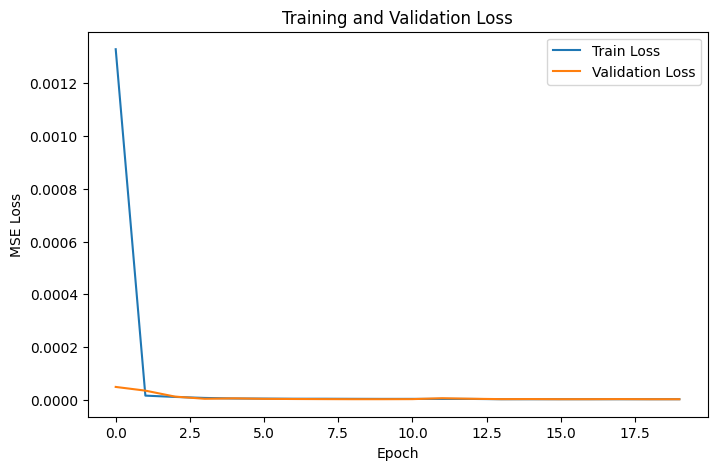

<ipython-input-8-95057a67ff59>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


RMSE (scaled): 0.001639963960
RMSE (unscaled): 59.949160043428


In [ ]:
# 5. Plot Training/Validation Loss
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

# -------------------------------
# 6. Model Evaluation (RMSE)
# -------------------------------
model.load_state_dict(torch.load("best_model.pth"))
model.eval()
predictions, actuals = [], []

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device).unsqueeze(-1)
        preds = model(x_test)
        predictions.extend(preds.cpu().numpy().flatten())
        actuals.extend(y_test.cpu().numpy().flatten())

predictions, actuals = np.array(predictions), np.array(actuals)
rmse_scaled = np.sqrt(mean_squared_error(actuals, predictions))
print(f"RMSE (scaled): {rmse_scaled:.12f}")

# Invert scaling
predictions_unscaled = scaler.inverse_transform(
    np.hstack([np.zeros((len(predictions), 3)), predictions.reshape(-1, 1)])
)[:, -1]

actuals_unscaled = scaler.inverse_transform(
    np.hstack([np.zeros((len(actuals), 3)), actuals.reshape(-1, 1)])
)[:, -1]

# Calculate RMSE
rmse_unscaled = np.sqrt(mean_squared_error(actuals_unscaled, predictions_unscaled))
print(f"RMSE (unscaled): {rmse_unscaled:.12f}")


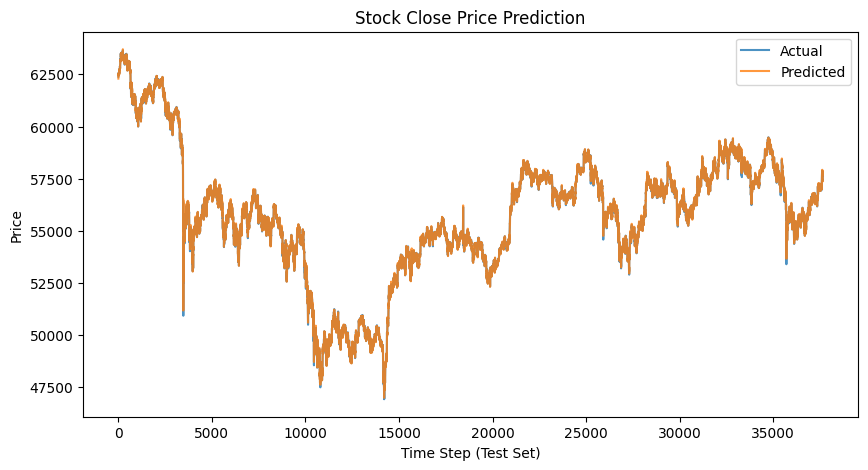

In [ ]:
# 7. Plot Predictions vs. Actual
# -------------------------------
plt.figure(figsize=(10, 5))
plt.plot(actuals_unscaled, label='Actual', alpha=0.8)
plt.plot(predictions_unscaled, label='Predicted', alpha=0.8)
plt.title('Stock Close Price Prediction')
plt.xlabel('Time Step (Test Set)')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:

model.load_state_dict(torch.load("best_model.pth"))

<ipython-input-11-4e55fec23aa2>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


<All keys matched successfully>

In [ ]:
model.eval()

# Prepare the last sequence from the test set
last_sequence = X_test[-1]  # Starting sequence, shape: (seq_length, num_features)

with torch.no_grad():
    # Convert the last sequence to tensor
    input_tensor = torch.from_numpy(last_sequence).float().unsqueeze(0).to(device)  # Shape: (1, seq_length, num_features)

    # Predict the next value
    next_scaled = model(input_tensor).cpu().numpy().flatten()  # Shape: (1,)

    # Create a new row for the sequence
    next_row = np.zeros((1, last_sequence.shape[1]))  # Shape: (1, num_features)
    next_row[0, -1] = next_scaled[0]  # Assign the predicted target to the last column

    # Update the sequence: drop the oldest row, add the new row
    next_value = np.vstack([last_sequence[1:], next_row])

    # Update the last sequence for future use (optional)
    last_sequence = next_value

# Print the scaled prediction
print("Predicted Scaled Value for the Next Day:", next_scaled[0])

# If you need the unscaled prediction
next_scaled = np.array(next_scaled).reshape(-1, 1)

# Inverse transform to get the unscaled value
num_features = scaler.n_features_in_  # Total features used during scaling
zero_array = np.zeros((len(next_scaled), num_features - 1))  # Placeholder for non-target features
input_for_inverse_transform = np.hstack([zero_array, next_scaled])
next_unscaled = scaler.inverse_transform(input_for_inverse_transform)[:, -1]  # Extract the unscaled target

print("Predicted Unscaled Value for the Next Day:", next_unscaled[0])


Predicted Scaled Value for the Next Day: 0.80024153
Predicted Unscaled Value for the Next Day: 57382.965168073766


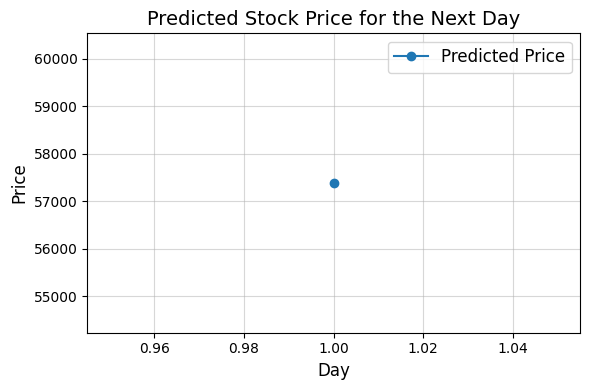

In [ ]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(6, 4))

# Plot the prediction for one day
plt.plot([1], [next_unscaled[0]], marker='o', linestyle='-', label="Predicted Price")

# Add title and labels
plt.title("Predicted Stock Price for the Next Day", fontsize=14)
plt.xlabel("Day", fontsize=12)
plt.ylabel("Price", fontsize=12)

# Add grid and legend
plt.grid(alpha=0.5)
plt.legend(fontsize=12)

# Ensure the plot is displayed
plt.tight_layout()
plt.show()


In [ ]:
# Assuming `next_30_days_scaled` contains scaled predictions (shape: [30, 1])

import numpy as np

# Reshape predictions if necessary
next_30_days_scaled = np.array(next_30_days_scaled).reshape(-1, 1)

# Prepare a zero array for non-target features
num_features = scaler.n_features_in_  # Total features used during scaling
zero_array = np.zeros((len(next_30_days_scaled), num_features - 1))  # Placeholder for non-target features

# Concatenate scaled target predictions with zeros for other features
input_for_inverse_transform = np.hstack([zero_array, next_30_days_scaled])  # Shape: [30, num_features]

# Perform inverse transformation to get unscaled prices
next_30_days_unscaled = scaler.inverse_transform(input_for_inverse_transform)[:, -1]  # Extract the unscaled target

# Display unscaled prices
print("Predicted Unscaled Prices for the Next 30 Days:")
print(next_30_days_unscaled)


In [ ]:
from datetime import datetime

# Timestamp in milliseconds
timestamp_ms = 1620794399999

# Convert to seconds
timestamp_s = timestamp_ms / 1000

# Convert to datetime
date = datetime.utcfromtimestamp(timestamp_s)  # Convert to UTC datetime
print("UTC Date:", date)

# Optional: Convert to local time
local_date = datetime.fromtimestamp(timestamp_s)  # Convert to local datetime
print("Local Date:", local_date)

UTC Date: 2021-05-12 04:39:59.999000
Local Date: 2021-05-12 04:39:59.999000


In [ ]:
predictions = np.array(predictions).reshape(-1)  # Ensure it's a flat array

# Create a zero array with the same number of rows as predictions
zero_array = np.zeros((len(predictions), 3))  # 3 corresponds to the non-target features

# Concatenate properly
predictions_unscaled = scaler.inverse_transform(
    np.hstack([zero_array, predictions.reshape(-1, 1)])
)[:, -1]
print("Zero array shape:", zero_array.shape)
print("Predictions shape:", predictions.reshape(-1, 1).shape)